In [1]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of a girl"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")


/home/t-jiaweiwang/miniconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


100%|██████████| 50/50 [00:01<00:00, 27.52it/s]


In [14]:
pipe.scheduler.betas.shape

torch.Size([1000])

In [25]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import numpy as np

# 加载模型
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

def generate_noisy_image(image, alpha_t):
    eta = torch.randn_like(image)
    alpha_t_sqrt = torch.sqrt(torch.tensor(alpha_t))
    one_minus_alpha_t_sqrt = torch.sqrt(1 - torch.tensor(alpha_t))
    noisy_image = alpha_t_sqrt * image + one_minus_alpha_t_sqrt * eta
    return noisy_image

# 假设 x0 是一个初始图像，我们先加载并预处理它
initial_image = Image.open("adversarial_images/prompt_constrained_16.bmp").convert("RGB")
initial_image = initial_image.resize((512, 512))
initial_image = torch.tensor(np.array(initial_image)).float() / 255.0
initial_image = initial_image.permute(2, 0, 1).unsqueeze(0).to("cuda")

# 选择 alpha_t
alpha_t_values = [0.25, 0.5, 0.75, 0.95]
alpha_t = alpha_t_values[3]  # 选择其中一个 alpha_t 值
noisy_image = generate_noisy_image(initial_image, alpha_t)

# 定义去噪函数
def denoise_image(pipe, noisy_image):
    # 使用模型去噪，不提供prompt
    with torch.autocast("cuda"):
        output = pipe(
            prompt="", 
            init_image=noisy_image, 
            strength=0.75,
            guidance_scale=0  # guidance_scale设置为0以忽略prompt的影响
        ).images[0]
    return output

# 去噪带噪声的图像
denoised_image = denoise_image(pipe, noisy_image)

# 保存去噪后的图像
denoised_image.save("denoised_output.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 25.40it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


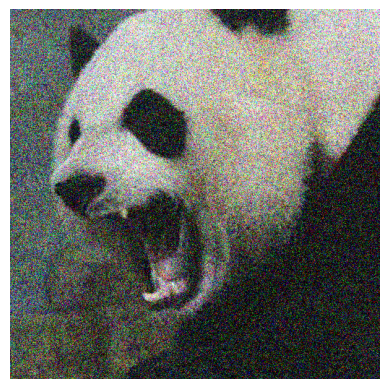

In [26]:
# 展示噪声图像
import matplotlib.pyplot as plt
plt.imshow(noisy_image[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [1]:
from PIL import Image
import numpy as np

# Load the image
image_path = 'adversarial_images/clean.jpeg'
image = Image.open(image_path)
image_np = np.array(image).astype(np.float32) / 255.0  # Normalize the image to [0, 1]

# Set the noise parameters
noise_mean = 0.0
noise_std = 16 / 255.0

# Generate random Gaussian noise
noise = np.random.normal(noise_mean, noise_std, image_np.shape)

# Add noise to the image and clip the result to [0, 1]
noisy_image_np = np.clip(image_np + noise, 0.0, 1.0)

# Convert the noisy image back to an unsigned 8-bit integer format
noisy_image = (noisy_image_np * 255).astype(np.uint8)

# Convert the NumPy array back to an image
noisy_image_pil = Image.fromarray(noisy_image)

# Save the noisy image
output_path = 'adversarial_images/random_noisy_constrained_16.bmp'
noisy_image_pil.save(output_path)

output_path

'adversarial_images/random_noisy_constrained_16.bmp'

In [2]:
import cv2
import numpy as np

def add_gaussian_noise(image, mean=0, stddev=0.1):
    # 生成与图像同大小的高斯噪声
    gaussian_noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = image + gaussian_noise
    return np.clip(noisy_image, 0, 1)  # 将图像像素值裁剪到[0,1]范围

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    # 添加盐噪声（白色噪点）
    num_salt = np.ceil(salt_prob * image.size)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy_image[coords] = 1
    
    # 添加胡椒噪声（黑色噪点）
    num_pepper = np.ceil(pepper_prob * image.size)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy_image[coords] = 0
    return noisy_image

def add_poisson_noise(image):
    # 生成泊松噪声
    noisy_image = np.random.poisson(image * 255.0) / 255.0
    return np.clip(noisy_image, 0, 1)

def add_combined_noise(image, noise_level=(-64/255, 64/255)):
    # 添加各种噪声
    noisy_image = add_gaussian_noise(image, stddev=0.1)
    # noisy_image = add_salt_and_pepper_noise(noisy_image, salt_prob=0.01, pepper_prob=0.01)
    # noisy_image = add_poisson_noise(image)
    
    # 确保最终噪声扰动在指定范围内
    noise = np.clip(noisy_image - image, noise_level[0], noise_level[1])
    final_noisy_image = np.clip(noisy_image, 0, 1)
    # final_noisy_image = np.clip(image + noise, 0, 1)
    
    return final_noisy_image

# 示例用法
# 读取图像，并将像素值归一化到[0,1]
image = cv2.imread('adversarial_images/clean.jpeg').astype(np.float32) / 255.0

# 添加组合噪声
noisy_image = add_combined_noise(image, noise_level=(-64/255, 64/255))

# 保存或显示添加噪声后的图像
cv2.imwrite('adversarial_images/clean_std_01.bmp', (noisy_image * 255).astype(np.uint8))

True